In [59]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [60]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [184]:
import torch
from PIL import Image
from IPython.display import display
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from fastseg import MobileV3Large
from fastseg.image import colorize, blend

print(torch.__version__)

2.4.0+cu121


In [104]:
model = MobileV3Large.from_pretrained().eval()

Loading pretrained model mobilev3large-lraspp with F=128...


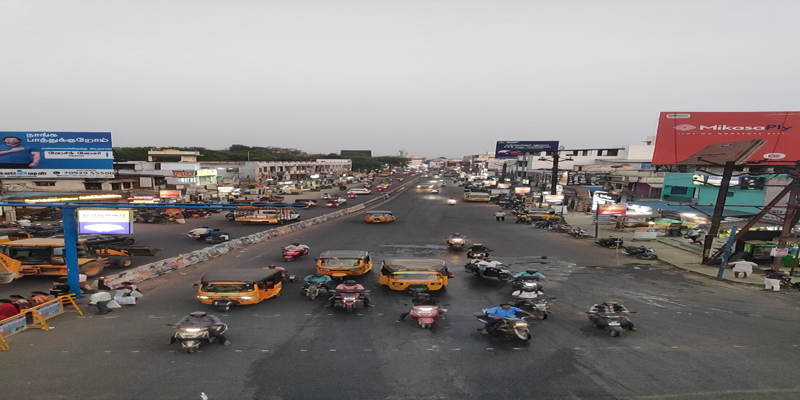

In [236]:
img = Image.open('/content/0.jpg')
display(img.resize((800, 400)))

In [286]:
labels = model.predict_one(img)
print('Shape:', labels.shape)
print(labels)

Shape: (1920, 1080)
[[10 10 15 ... 15 15 15]
 [10 10 15 ... 15 15 15]
 [10 10 15 ... 15 15 15]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


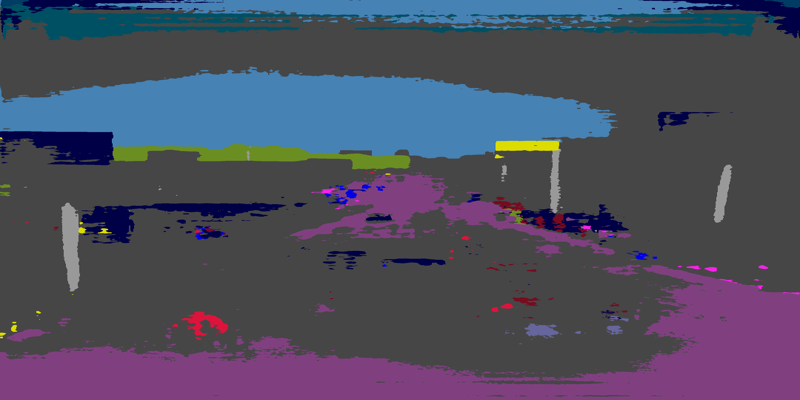

In [287]:
colorized = colorize(labels)
display(colorized.resize((800, 400)))

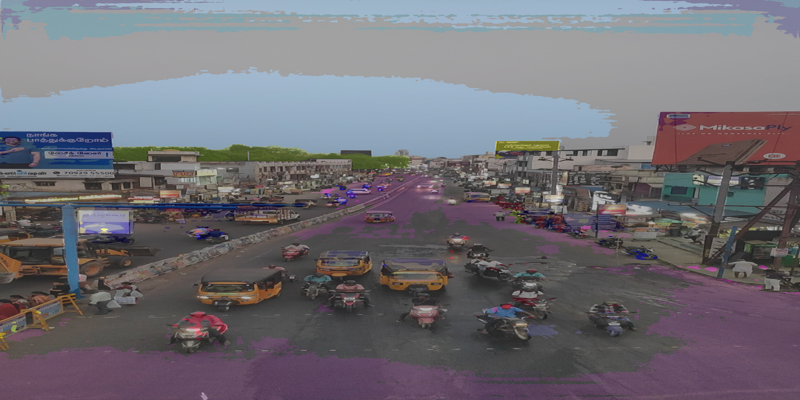

In [288]:

composited = blend(img, colorized)
display(composited.resize((800, 400)))

In [289]:
def remove_small_segments(mask, min_area_threshold=100):
    _, labels, stats, _ = cv.connectedComponentsWithStats(mask.astype(np.uint8))

    filtered_mask = np.zeros_like(mask)
    for label, stat in enumerate(stats[1:], start=1):
        if stat[4] >= min_area_threshold:
            filtered_mask[labels == label] = 1

    return filtered_mask

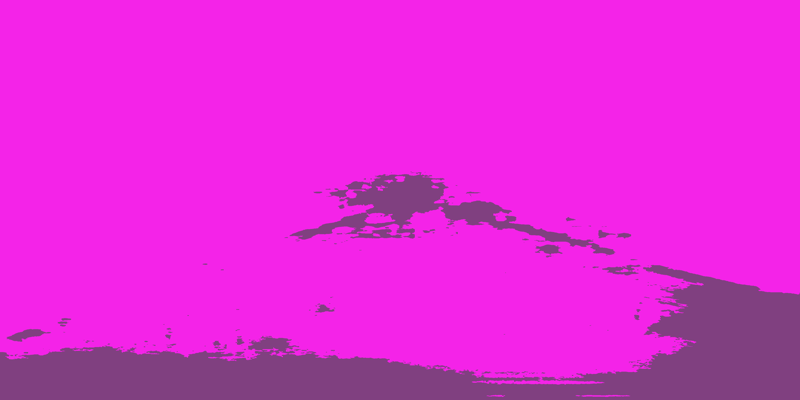

In [290]:
filtered_mask = remove_small_segments(labels, min_area_threshold=100)

colorized = colorize(filtered_mask)
display(colorized.resize((800, 400)))

In [291]:
threshold_value = 0.5
binary_mask = np.where(filtered_mask > threshold_value, 1, 0)

grayscale_mask = binary_mask.astype(np.uint8) * 255

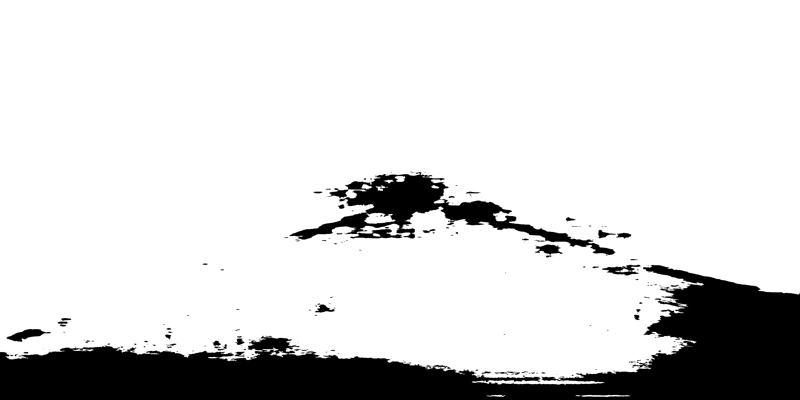

In [292]:
image = Image.fromarray(grayscale_mask)
display(image.resize((800, 400)))

In [293]:
kernel = np.ones((5, 5), np.uint8)
eroded_array = cv.erode(grayscale_mask, kernel, iterations=3)

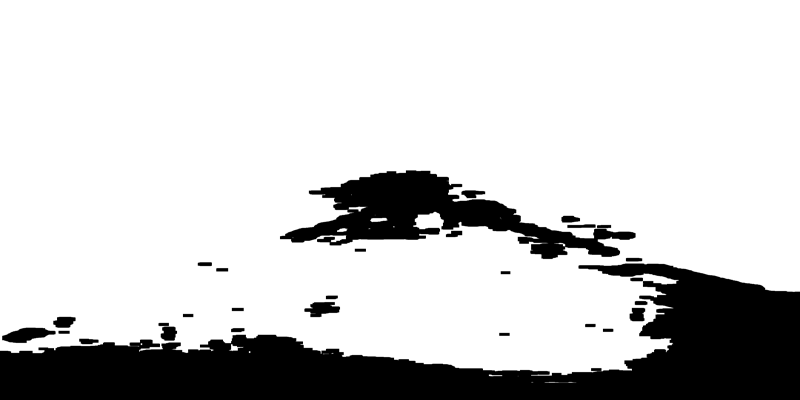

In [294]:
image = Image.fromarray(eroded_array)
display(image.resize((800, 400)))

In [295]:
def road_points(mask, threshold=50):
  top = None
  left = None
  right = None

  # top
  for y in range(mask.shape[0]):
    for x in range(mask.shape[1] - 1, -1, -1):
        if mask[y, x] < threshold:
            top = (x, y)
            # cv.circle(mask, (x, y), 10, (0, 255, 0), -1)
            break
    if top is not None:
        break

  # right
  for x in range(mask.shape[1] - 1, -1, -1):
    for y in range(mask.shape[0]):
      if mask[y, x] < threshold:
            right = (x, y)
            # cv.circle(mask, (x, y), 30, (0, 255, 0), -1)
            break
    if right is not None:
        break

  for x in range(mask.shape[1]):
    for y in range(mask.shape[0]):
  # for x in range(mask.shape[1]):
  #   for y in range(mask.shape[0] - 1, -1, -1):
        if mask[y, x] < threshold:
            left = (x, y)
            # cv.circle(mask, (x, y), 30, (0, 255, 0), -1)
            break
    if left is not None:
        break

  return top, right, left

In [296]:
top, right, left = road_points(eroded_array)
print(top, right, left)

(561, 818) (1079, 1400) (0, 1684)


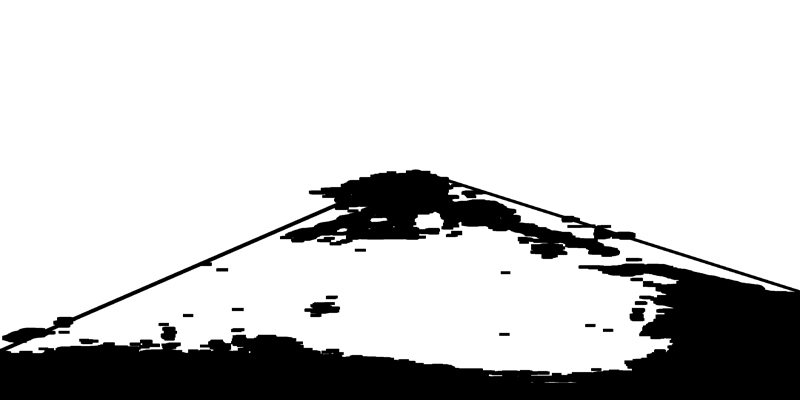

In [297]:
eroded_array = cv.line(eroded_array, (top[0], top[1]), (left[0], left[1]), (0, 255, 0), 10)
eroded_array = cv.line(eroded_array, (top[0], top[1]), (right[0], right[1]), (0, 255, 0), 10)

image = Image.fromarray(eroded_array)
display(image.resize((800, 400)))

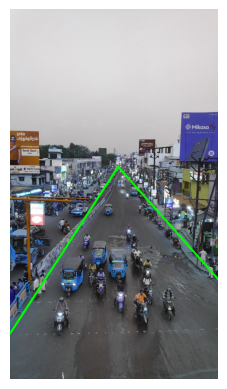

In [298]:
numpy_image = np.array(img)
real_image = cv.cvtColor(numpy_image, cv.COLOR_RGB2BGR)

real_image = cv.line(real_image, (top[0], top[1]), (left[0], left[1]), (0, 255, 0), 10)
real_image = cv.line(real_image, (top[0], top[1]), (right[0], right[1]), (0, 255, 0), 10)

plt.imshow(real_image)
plt.axis('off')
plt.show()

In [299]:
real_image.shape


(1920, 1080, 3)

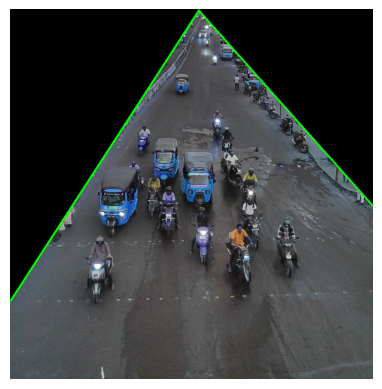

In [345]:
polygon = np.array([[0, 1920], [left[0], left[1]], [top[0], top[1]], [right[0], right[1]], [1080,1920]],  np.int32)
polygon = polygon.reshape((-1, 1, 2))

mask = np.zeros(real_image.shape[:2], dtype=np.uint8)
cv.fillPoly(mask, [polygon], 255)

masked_image = cv.bitwise_and(real_image, real_image, mask=mask)

x, y, w, h = cv.boundingRect(polygon)
cropped_image = masked_image[y:y+h, x:x+w]

plt.imshow(cropped_image)
plt.axis('off')
plt.show()